# Utils

In [60]:
import sys
sys.path.append('/home/huyvvo/rsc/fairvit')
import numpy as np
from fairvit.data import make_data_loader, make_dataset, SamplerType
from time import time
import matplotlib.pyplot as plt


import torch
import pandas as pd
import seaborn as sns
import torchvision.transforms.functional as F
torch.set_grad_enabled(False)
import torchvision.transforms as T
import torch.nn as nn
from tqdm import trange, tqdm
from PIL import Image, ImageDraw
import torchvision
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import argparse
from matplotlib import cm
from pathlib import Path

from torch import nn
sns.set_theme(style="darkgrid")
torch.set_grad_enabled(False)
from collections import Counter

In [123]:
# read linear, knn, fine-grained, depth, seg, retrieval

def _read_linear_eval_from_json_file(filename):
    if not Path(filename).exists():
        raise FileNotFoundError(f'Eval file {filename} not found!')
    eval_results = {}
    current_iter = -1
    last_iter = -1
    with open(filename, 'r') as f: 
        for line in f:
            words = line.strip().split(' ')
            if len(words) == 2:
                if words[0] != 'iter:':
                    raise Exception(f'Error while reading {filename}')
                current_iter = int(words[1])
                if current_iter in eval_results:
                    raise Exception(f'Duplicated iters in {filename}')
            elif len(words) > 2:
                if current_iter == -1:
                    raise Exception(f'Error while reading {filename}')
                acc_data = json.loads(line.strip())
                try:
                    eval_results[current_iter] = acc_data['best_classifier']['accuracy']
                except:
                    eval_results[current_iter] = acc_data['best classifier']['accuracy']
                last_iter = current_iter
                current_iter = -1
            else:
                continue
    if 12500 in eval_results:
        return eval_results[12500] * 100
    elif 11249 in eval_results:
        return eval_results[11249] * 100
    else:
        raise Exception(f'Evaluating at iteration {last_iter} in {filename}')
def _read_linear_eval_from_csv_file(filename):
    df = pd.read_csv(filename)
    return df['ImageNet:split=VAL_accuracy'].values[0]

def _read_linear_acc(eval_dir):
    try:
        return _read_linear_eval_from_csv_file(Path(eval_dir, 'linear/linear_ood/results-linear.csv'))
    except:
        return _read_linear_eval_from_json_file(Path(eval_dir, 'linear/linear_ood/results_eval_linear.json'))
         
def read_linear_acc(exp_dir):
    eval_dirs = list(Path(exp_dir).glob('eval/training_*'))
    iters = []
    acc = []
    for _eval in eval_dirs:
        try:
            acc.append(_read_linear_acc(_eval))
            iters.append(int(str(_eval).split('_')[-1]))
        except FileNotFoundError as fe:
            print(str(fe))
        except Exception as e:
            print(str(e))
    ids = np.argsort(iters)
    iters = np.array(iters)[ids]
    acc = np.array(acc)[ids]
    return iters, acc

def _read_knn_acc_from_json_file(filename):
    if not Path(filename).exists():
        raise FileNotFoundError(f'Eval file {filename} not found!')
    with open(filename, 'r') as f:
        line = f.readline()
    return json.loads(line)["('full', 10) Top 1"]
    
def _read_knn_acc_from_csv_file(filename):
    df = pd.read_csv(filename)
    return df["('full', 10) Top 1"].values[0]
    
def _read_knn_acc(eval_dir):
    try:
        return _read_knn_acc_from_csv_file(Path(eval_dir, 'knn/knn_imagenet1k/results-knn.csv'))
    except:
        return _read_knn_acc_from_json_file(Path(eval_dir, 'knn/knn_imagenet1k/results_eval_knn.json'))
        
def read_knn_acc(exp_dir):
    eval_dirs = list(Path(exp_dir).glob('eval/training_*'))
    iters = []
    acc = []
    for _eval in eval_dirs:
        try:
            acc.append(_read_knn_acc(_eval))
            iters.append(int(str(_eval).split('_')[-1]))
        except:
            continue
    ids = np.argsort(iters)
    iters = np.array(iters)[ids]
    acc = np.array(acc)[ids]
    return iters, acc

def visualize_linear_knn(exp_dirs, legends, linestyles, markers, **kwargs):
    # get key-word arguments
    figsize = kwargs.get('figsize', (20, 8))
    iter_lims = kwargs.get('iter_lims', (0, 1e7))
    major_pace = kwargs.get('major_pace', 0.5)
    minor_pace = kwargs.get('minor_pace', major_pace/5)
    font_size = kwargs.get('font_size', 20)
    
    metrics = ['linear_acc', 'knn']
    readers = [read_linear_acc, read_knn_acc]
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    for _met_idx, _met in enumerate(metrics):
        acc_info = {'min':np.Inf, 'max':-np.Inf}
        for exp_dir_idx, exp_dir in enumerate(exp_dirs):
            iters, acc = readers[_met_idx](exp_dir)
            acc = acc[np.logical_and(iters >= iter_lims[0], iters <= iter_lims[1])]
            iters = iters[np.logical_and(iters >= iter_lims[0], iters <= iter_lims[1])]
            if len(acc) > 0:
                axs[_met_idx].plot(
                    iters, acc, linestyle=linestyles[exp_dir_idx], 
                    label=legends[exp_dir_idx], marker=markers[exp_dir_idx],
                )
                acc_info['min'] = min(acc_info['min'], min(acc))
                acc_info['max'] = max(acc_info['max'], max(acc))
        
        # set yticks
        axs[_met_idx].set_yticks(
            ticks=np.arange(
                (np.floor(acc_info['min'] / major_pace) - 2) * major_pace,
                (np.ceil(acc_info['max'] / major_pace) + 1) * major_pace,
                major_pace),
        )
        axs[_met_idx].tick_params(labelsize=font_size)
        axs[_met_idx].yaxis.set_major_locator(MultipleLocator(major_pace))
        axs[_met_idx].yaxis.set_minor_locator(MultipleLocator(minor_pace))
        
        axs[_met_idx].legend(fontsize=font_size)
        axs[_met_idx].set_facecolor((1.0, 1.0, 1.0))
        axs[_met_idx].grid(visible=True, which='major', color='#BBBBBB', linestyle='-')
        axs[_met_idx].grid(visible=True, which='minor', color='#DDDDDD', linestyle='--')
        axs[_met_idx].set_title(_met, fontsize=20)
        
    plt.show()  
        
def visualize_performance(exp_dir, perf_type, **kwargs):
    pass
    

# VEG runs

# Data curation run

Evaluating at iteration 6249 in /home/huyvvo/projects/veg/vis_experiments/paper_runs/230202_sharded_selection_4_phases_rccc_100M_3_10_50_70_ver1/eval/training_324999/linear/linear_ood/results_eval_linear.json
Eval file /home/huyvvo/projects/veg/vis_experiments/paper_runs/230202_sharded_selection_4_phases_rccc_100M_3_10_50_70_ver1/eval/training_337499/linear/linear_ood/results_eval_linear.json not found!
Evaluating at iteration 7499 in /home/huyvvo/projects/veg/vis_experiments/paper_runs/230202_sharded_selection_4_phases_rccc_100M_3_10_50_70_ver1_vith/eval/training_187499/linear/linear_ood/results_eval_linear.json
Eval file /home/huyvvo/projects/veg/vis_experiments/paper_runs/230202_sharded_selection_4_phases_rccc_100M_3_10_50_70_ver1_vith/eval/training_524999/linear/linear_ood/results_eval_linear.json not found!


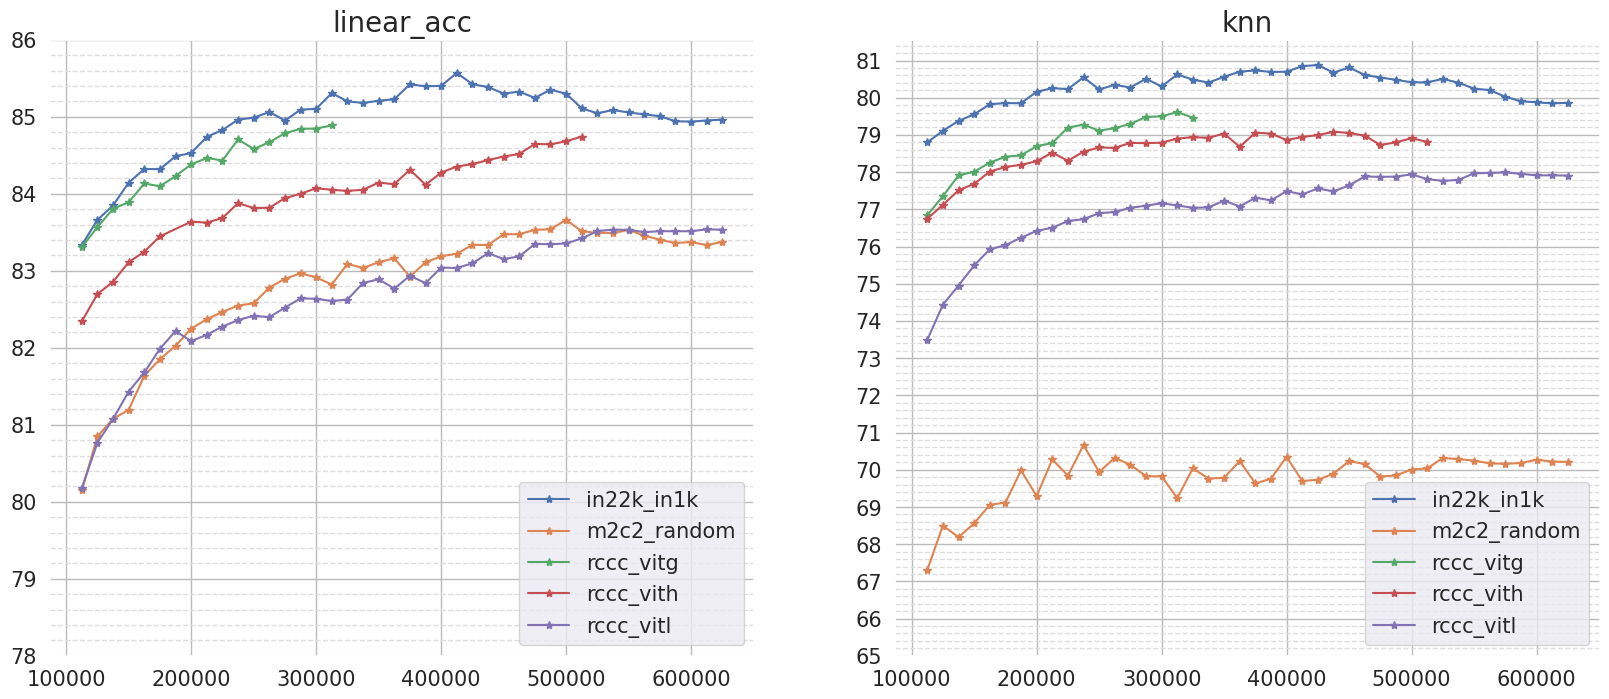

In [128]:
import json
exp_dirs = [
    '/home/huyvvo/projects/veg/vis_experiments/paper_runs/in22k_in1k',
    '/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random',
    '/home/huyvvo/projects/veg/vis_experiments/paper_runs/230202_sharded_selection_4_phases_rccc_100M_3_10_50_70_ver1',
    '/home/huyvvo/projects/veg/vis_experiments/paper_runs/230202_sharded_selection_4_phases_rccc_100M_3_10_50_70_ver1_vith',
    '/home/huyvvo/projects/veg/vis_experiments/paper_runs/230202_sharded_selection_4_phases_rccc_100M_3_10_50_70_ver1_vitl',
]

legends = [
    'in22k_in1k',
    'm2c2_random',
    'rccc_vitg',
    'rccc_vith',
    'rccc_vitl',
]

linestyles = ['-'] * len(exp_dirs)
markers = ['*'] * len(exp_dirs)

visualize_linear_knn(exp_dirs, legends, linestyles, markers, iter_lims=[1e5,1e6], font_size=15, major_pace=1)

In [16]:
pd.read_csv('')

{'best_classifier': {'name': 'classifier_4_blocks_avgpool_True_lr_0_08000',
  'accuracy': 0.3115600049495697}}

In [49]:
list(Path('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random').glob('eval/training_*'))

[PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_112499'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_12499'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_124999'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_137499'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_149999'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_162499'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_174999'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_187499'),
 PosixPath('/home/huyvvo/projects/veg/vis_experiments/paper_runs/m2c2_142M_random/eval/training_199999'),
 PosixPath('/home/huyvvo/projects/veg/vis_exper